# Objective: For each ID in the test set, you must predict 1 if the tweet is describing a real disaster, and 0 otherwise.

# 1. Basic Feature Extraction



Guide: https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove

## Prelude

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt                                                 # for visualisation
import seaborn as sns
import re                                                                       # for regular expression
import string                                                                   # for handling string
import math                                                                     # for math
from pandas_profiling import ProfileReport

import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from textblob import TextBlob

from collections import defaultdict                                             # for EDA

from sklearn.metrics import confusion_matrix                                    # for the modelling and plotting of curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier                         # for feature engineering
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [2]:
train_csv = 'C:/Users/zheng/Desktop/Data Science/Capstone Project/Data//train.csv'
test_csv = 'C:/Users/zheng/Desktop/Data Science/Capstone Project/Data//test.csv'

train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

pd.set_option("display.max_colwidth", None)


In [3]:
profile_train = ProfileReport(train, title="Train Profiling Report")

profile_train

In [4]:
profile_test = ProfileReport(test, title="Test Profiling Report")

profile_test

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


<AxesSubplot:title={'center':'Null values present in train Dataset'}>

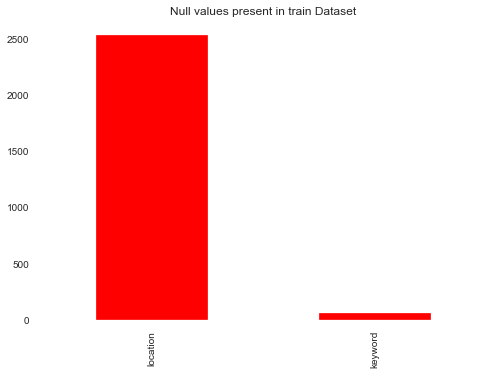

In [6]:
missing = train.isnull().sum()  
missing[missing>0].sort_values(ascending=False).plot(kind='bar',title='Null values present in train Dataset', color=['red'])

In [7]:
train.shape

(7613, 5)

In [8]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

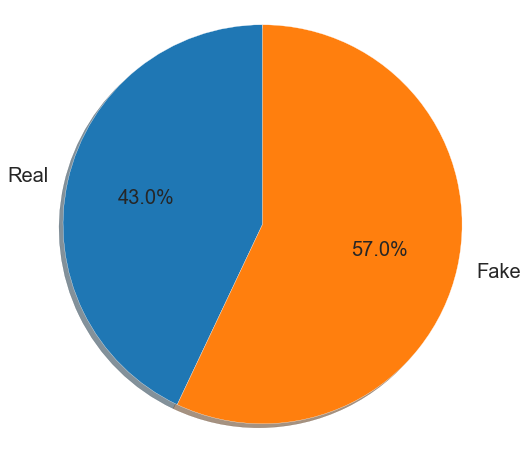

In [9]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Real', 'Fake'
sizes = [3271, 4342]

fig1, ax1 = plt.subplots(figsize=(8,8))
_ = ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, textprops={'fontsize': 20})
_ = ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

_ = plt.show()

### 1.1 Number of Words

One of the most basic features we can extract is the number of words in each tweet. The basic intuition behind this is that generally, the negative sentiments contain a lesser amount of words than the positive ones.

To do this, we simply use the split function in python:

In [10]:
train.index = train.index + 1

In [11]:
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
train[['text','word_count']].head()

,text,word_count
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,13
2,Forest fire near La Ronge Sask. Canada,7
3,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,22
4,"13,000 people receive #wildfires evacuation orders in California",9
5,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,17


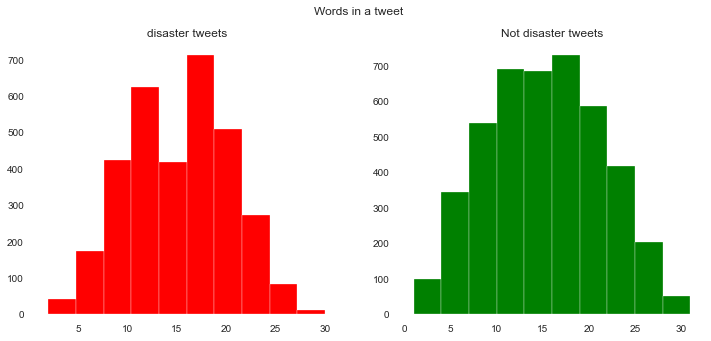

In [12]:
_ = fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

train_len1a =train[train['target']==1]['text'].str.split().map(lambda x: len(x))
_ = ax1.hist(train_len1a,color='red')
_ = ax1.set_title('disaster tweets')

train_len2a = train[train['target']==0]['text'].str.split().map(lambda x: len(x))
_ = ax2.hist(train_len2a,color='green')
_ = ax2.set_title('Not disaster tweets')
_ = fig.suptitle('Words in a tweet')
_ = plt.show()

### 1.2 Number of characters

This feature is also based on the previous feature intuition. Here, we calculate the number of characters in each tweet. This is done by calculating the length of the tweet.

In [13]:
train['char_count'] = train['text'].str.len() ## this also includes spaces
train[['text','char_count']].head()

,text,char_count
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,69
2,Forest fire near La Ronge Sask. Canada,38
3,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,133
4,"13,000 people receive #wildfires evacuation orders in California",65
5,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,88


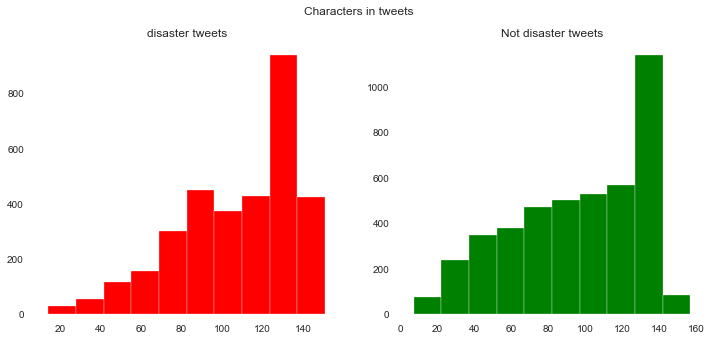

In [14]:
_ = fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

train_len1b = train[train['target']==1]['text'].str.len()
_ = ax1.hist(train_len1b,color='red')
_ = ax1.set_title('disaster tweets')

train_len2b=train[train['target']==0]['text'].str.len()
_ = ax2.hist(train_len2b,color='green')
_ = ax2.set_title('Not disaster tweets')
_ = fig.suptitle('Characters in tweets')
_ = plt.show()

The distribution of both seems to be almost same. 120 t0 140 characters in a tweet are the most common among both.

### 1.3 Average Word Length

We will also extract another feature which will calculate the average word length of each tweet. This can also potentially help us in improving our model.

Here, we simply take the sum of the length of all the words and divide it by the total length of the tweet:

In [15]:
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

train['avg_word'] = train['text'].apply(lambda x: avg_word(x))
train[['text','avg_word']].head()

,text,avg_word
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,4.384615
2,Forest fire near La Ronge Sask. Canada,4.571429
3,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,5.090909
4,"13,000 people receive #wildfires evacuation orders in California",7.125000
5,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,4.500000


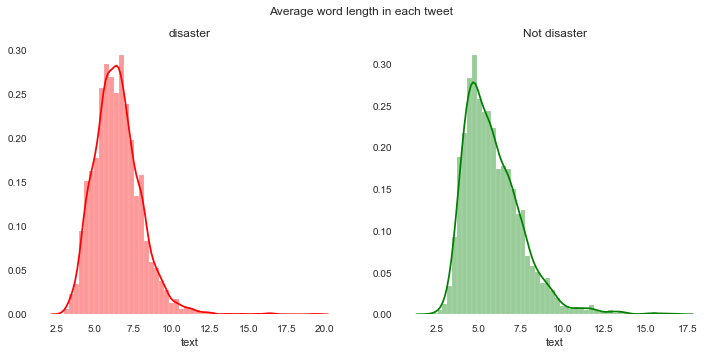

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

word1c =train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
_ = sns.distplot(word1c.map(lambda x: np.mean(x)),ax=ax1,color='red')
_ = ax1.set_title('disaster')

word2c = train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
_ = sns.distplot(word2c.map(lambda x: np.mean(x)),ax=ax2,color='green')
_ = ax2.set_title('Not disaster')
_ = fig.suptitle('Average word length in each tweet')

### 1.4 Number of stopwords

Generally, while solving an NLP problem, the first thing we do is to remove the stopwords. But sometimes calculating the number of stopwords can also give us some extra information which we might have been losing before.

Here, we have imported stopwords from NLTK, which is a basic NLP library in python.

In [17]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

train['stopwords'] = train['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
train[['text','stopwords']].head()

,text,stopwords
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,5
2,Forest fire near La Ronge Sask. Canada,0
3,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,9
4,"13,000 people receive #wildfires evacuation orders in California",1
5,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,6


In [18]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

We do class 0 first.

In [19]:
corpus=create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

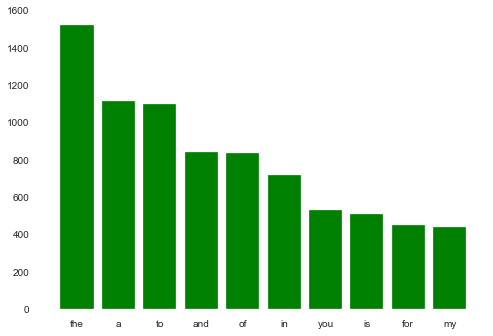

In [20]:
x,y=zip(*top)
_ = plt.bar(x,y, color='green')

Now we do class 1

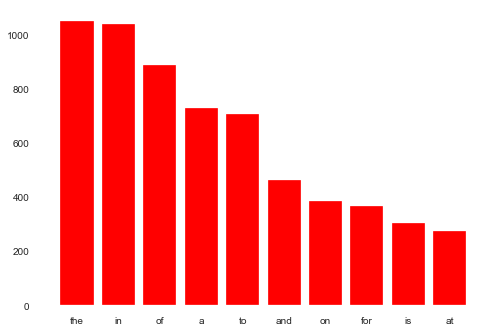

In [21]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    


x,y=zip(*top)
_ = plt.bar(x,y, color='r')

In both of them,"the" dominates which is followed by "a" in class 0 and "in" in class 1.

### 1.5 Number of special characters

One more interesting feature which we can extract from a tweet is calculating the number of hashtags or mentions present in it. This also helps in extracting extra information from our text data.

Here, we make use of the ‘starts with’ function because hashtags (or mentions) always appear at the beginning of a word.

In [22]:
train['hashtags'] = train['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
train[['text','hashtags']].head()

,text,hashtags
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
2,Forest fire near La Ronge Sask. Canada,0
3,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
4,"13,000 people receive #wildfires evacuation orders in California",1
5,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,2


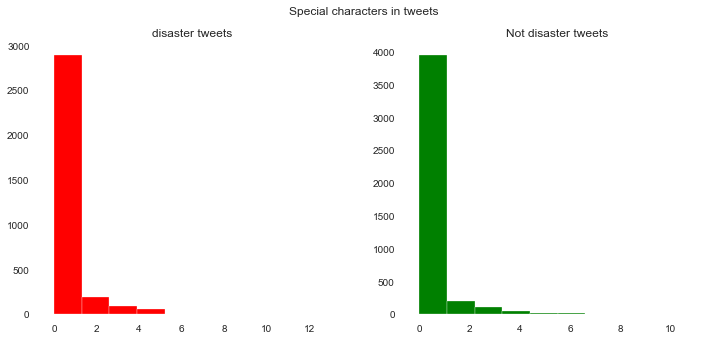

In [23]:
_ = fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

train_len1e = train[train['target']==1]['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
_ = ax1.hist(train_len1e,color='red')
_ = ax1.set_title('disaster tweets')

train_len2e=train[train['target']==0]['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
_ = ax2.hist(train_len2e,color='green')
_ = ax2.set_title('Not disaster tweets')
_ = fig.suptitle('Special characters in tweets')
_ = plt.show()

Both looks the same to me.

### 1.6 Punctuations

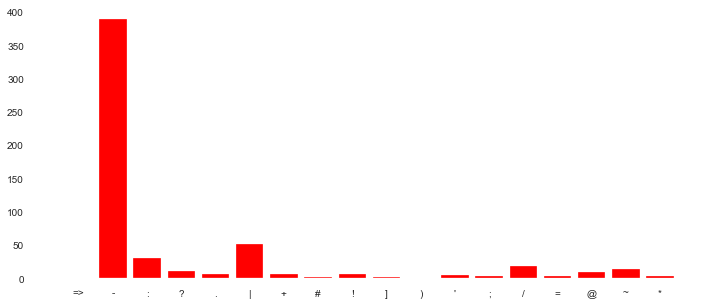

In [24]:
_ = plt.figure(figsize=(12,5))
corpus=create_corpus(1)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
_ = plt.bar(x,y, color='r')

Now we look at class 0

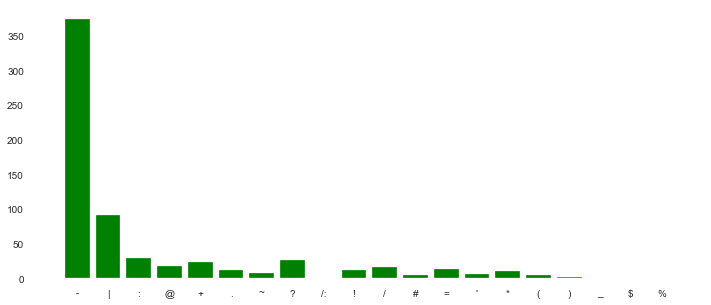

In [25]:
_ = plt.figure(figsize=(12,5))
corpus=create_corpus(0)

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
_ = plt.bar(x,y,color='green')

Both looks about the same.

### 1.7 Number of numerics

Just like we calculated the number of words, we can also calculate the number of numerics which are present in the tweets. 

In [26]:
train['numerics'] = train['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train[['text','numerics']].head()

,text,numerics
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0
2,Forest fire near La Ronge Sask. Canada,0
3,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
4,"13,000 people receive #wildfires evacuation orders in California",0
5,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0


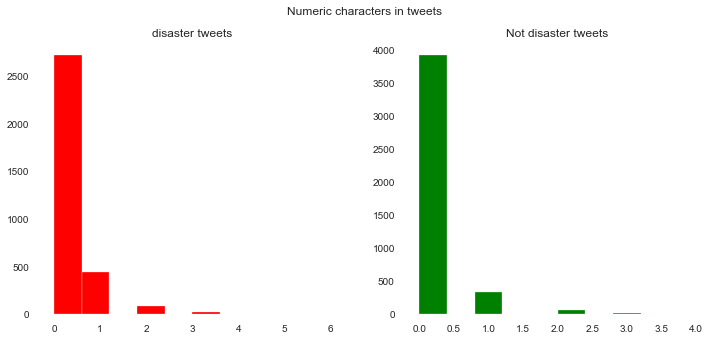

In [27]:
_ = fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

train_len1f = train[train['target']==1]['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
_ = ax1.hist(train_len1f,color='red')
_ = ax1.set_title('disaster tweets')

train_len2f=train[train['target']==0]['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
_ = ax2.hist(train_len2f,color='green')
_ = ax2.set_title('Not disaster tweets')
_ = fig.suptitle('Numeric characters in tweets')
_ = plt.show()

Again not much difference, although real disaster tend to use fewer numbers.

### 1.8 Number of Uppercase words
Anger or rage is quite often expressed by writing in UPPERCASE words which makes this a necessary operation to identify those words.

In [28]:
train['upper'] = train['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
train[['text','upper']].head()

,text,upper
1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
2,Forest fire near La Ronge Sask. Canada,0
3,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0
4,"13,000 people receive #wildfires evacuation orders in California",0
5,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0


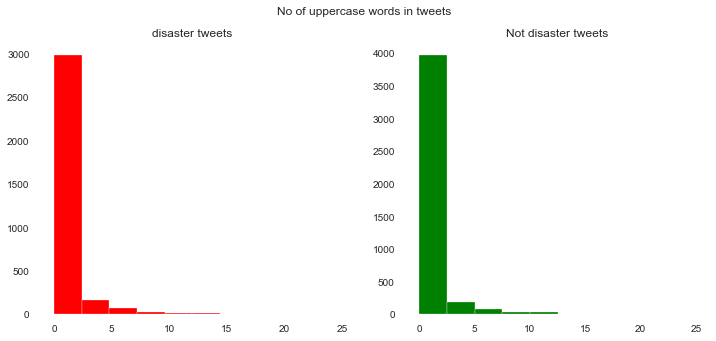

In [29]:
_ = fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

train_len1g = train[train['target']==1]['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
_ = ax1.hist(train_len1g,color='red')
_ = ax1.set_title('disaster tweets')

train_len2g=train[train['target']==0]['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
_ = ax2.hist(train_len2g,color='green')
_ = ax2.set_title('Not disaster tweets')
_ = fig.suptitle('No of uppercase words in tweets')
_ = plt.show()

Both look about the same.

# 2. Basic Pre-processing

So far, we have learned how to extract basic features from text data. Before diving into text and feature extraction, our first step should be cleaning the data in order to obtain better features. We will achieve this by doing some of the basic pre-processing steps on our training data.

So, let’s get into it.

### 2.1 Removal of http
We do not need the website/links for our text analysis, so we shall remove them.

In [30]:
def clean_text(text):
    text = re.sub(r'https://t.co\S+\s*', '', text)  # remove URLs http://t.co/lbwej0pxOd
    text = re.sub(r'http://t.co\S+\s*', '', text) 
    return text

In [31]:
train['clean'] = train['text'].apply(clean_text)
train['clean'].sample(20)

6956                                                Tsunami - DVBBS &amp; Borgeous (Arceen Festival Trap Remix) via @YouTube
6210                                    niggas selling weed just so they can smoke &amp; stay high.  YALL NIGGA IN THE WAY..
5901                                                   Watch This Airport Get Swallowed Up By A Sandstorm In Under A Minute 
1871                                                                     Me trying to look cute wen crush is passing by ... 
1447                                                                                    That took way longer than I expected
1975                                           1970 Mercury Cyclone GT Quarter Panel D/S Rear Trim Moulding Cobra Jet 429CJ 
5847                                                                                               Always gotta ruin my mood
142           family members of osama bin laden have died in an airplane accident how ironic ?????? mhmmm gov shit i suspect


### 2.2 Remove Mentions

The account name is irrevelant to what we want to analyse so we shall remove them.

In [32]:
def clean_text1(text):
    text = re.sub(r'@\S+', '', text)  # remove mentions
    return text

In [33]:
train['clean'] = train['clean'].apply(clean_text1)
train['clean'].sample(20)

4161                                                           I trickshot with a regular controller fucking infinite fading is so harm &gt;:(
2219                                                                                                         I am for the deluge of HELL VINES
7438                                                                                         Nout like rubbin salt in the wounds dad.. ?????? 
5524                                                                   Alabama firefighters quarantined after possible Ebola exposure reports 
6350                             Photo: Failure in structural integrity affects us all. Whether it is a barn raised upon a faulty concrete... 
6650                                                   RT AbbsWinston: #Zionist #Terrorist Demolish Tire Repair Shop Structure in #Bethlehem\n
7276                                   Whirlwind that has lasted for more than an hour and still strong. A standstill in parts of middle east.

### 2.3 Remove RT
We do not have to know who is tagged or being tagged so we shall remove them. We can't remove "cc" because of "accident"

In [34]:
def clean_text2(text):
    text = re.sub(r'RT|^cc', '', text) # remove RT
    return text

In [35]:
train['clean'] = train['clean'].apply(clean_text2)
train['clean'].sample(20)

4758                                               Wolforth with a two-out single up the middle. Fourth hit of the night for Altamonte Springs.
1834                                                   Thief Broke Front Window Of Hicksville Store Stole 50 Cell Phones; Fled Crashed Into... 
727                   Keep thinking about it until I stepped on a broken glass pun tak sedar and I don't feel the pain also it's bleeding. Shit
6255                                    #LakeEffect #Snowstorm Twill Denim Jackets   *** ALL MY PROCEEDS FOR ITEMS WITH THIS DESIGN WILL GOÛ_ 
5545                               Due to the rainstorm last night cupcake decorating is happening NOW at the Rec Hall! $2 - proceeds to #IWK! 
778                                                                                                                  Zayn just blew up twitter.
6578                                                                  4 THOSE WHO CARE ABOUT SIBLING ABUSE SURVIVORS join the new family

### 2.4 Remove extra whitespace and special symbols

In [36]:
def clean_text3(text):
    text = re.sub(r'\s+$', '', text)
    text = re.sub(r'\^s+', '', text)
    text = re.sub(r'[^a-zA-Z\s]+', '', text) #remove special symbols
    return text

In [37]:
train['clean'] = train['clean'].apply(clean_text3)
train['clean'].sample(20)

4909                                                        \nParents of Colorado theater shooting victim fear copycat massacre\n\nAntioch
3407                                        Whether you like it or not everything comes out of the dark be ready for that shit to explode 
3442                                                                              The Dress Memes Have Officially Exploded On The Internet
5105                                        Fukushima mutant vegetable images sweep across the region two years after nuclear disaster via
7259                                                                                                   HELP IM IN A WHIRLWIND OF NOSTALGIA
3429                                                                                                             All these people explode 
5679                                               Man Who Buried Dog Alive Thought No One Would Find Her But She Was Rescued Just In Time
5398                       

### 2.5 Removing digits and words containing digits

Next, we need to remove numbers and words containing digits from the texts. I am doing this because digits and words containing digits do not give much importance to the main words. 

In [38]:
def clean_text4(text):
    text = re.sub(r'\w*\d\w*','', text)
    return text

In [39]:
train['clean'] = train['clean'].apply(clean_text4)
train['clean'].sample(20)

7049                                                                                            A GPM satellite bullseye in Typhoon Soudelor
1620      Spot fixingmatch fixing anyone\nOr it has to be Pak SL WI RSA or BD to say this Sham on them who say that when these team collapse
5523    okay the cat has been quarantined in my bathroomits meowing really loud but I turned up the TV louderthings just might work out okay
3540                                 Russian food crematoria provoke outrage amid crisis famine memories MOSCOW Reuters  Russian government 
3341                                WorldNews Fallen powerlines on Glink tram UPDATE FIRE crews have evacuated up to  passengers who were tr
2117                                                                  VIDEO Slain Mexican Journalist Unknowingly Predicted His Own Death via
5181                                                      Watch Sarah Palin OBLITERATE Planned Parenthood For Targeting Minority Women  BBSP
143          

### 2.6 Expand contractions

Contractions are the shortened versions of words like don’t for do not and how’ll for how will. These are used to reduce the speaking and writing time of words. We need to expand these contractions for a better analysis of the texts.

In [40]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}



In [41]:
# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
train['clean'] = train['clean'].apply(lambda x:expand_contractions(x))
train['clean'].sample(20)

334                                                                                     Sadly How Windows  Reveals Microsofts Ethics Armageddon
5573                          Yay I can feel the wind gearing up for a rainstorm in Vancouver Bring it on drought deadgrassandflowers wildfires
350                                                                                                     Beyonce Is my pick for Fan Army Beyhive
1015                                                                              No Caption Needed  Freshman nigga Stacey body bagging niggas 
6553                                     Planted  years ago it was moved to US This Bonsai Survived Hiroshima But Its Story Was Nearly Lost via
7256    Hey all you love birds We have been getting submissions for the Whirlwind Wedding Wars and they are so fantastic Keep sending them guys
2602                                                       years after ABomb destroyd HiroshimaBBC looks at wht survived CNV Watch Peace

Now that we have expanded the contractions, it’s time to lowercase the words.

### 2.7 Lower case
What we will do is transform our tweets into lower case. This avoids having multiple copies of the same words. For example, while calculating the word count, ‘Analytics’ and ‘analytics’ will be taken as different words.

In NLP, models treat words like Goat and goat differently, even if they are the same. Therefore, to overcome this problem, we lowercase the words. Here, I am using the lower() function available in Python for converting text to lowercase:

In [42]:
train['clean'] = train['clean'].apply(lambda x: " ".join(x.lower() for x in x.split()))
train['clean'].sample(20)

1768                                            traffic collision ambulance enroute elkhorn blvd at walerga rd sacramento
5485       wired reddit will now quarantine offensive content reddit cofounder and ceo steve huffman has unveiled more sp
529        secrets up avalanche catechize inner self for the confidential communication as respects creating worth in len
2802                                                                               my day has been a disaster of emotions
7377                                                           ian lees word is like a fart in a windstorm such a browner
4702                  flashflood causes landslide in gilgit pakistan damage to homes farmland roads and bridges disasters
6751                                                                            second tornado confirmed in sundays storm
2687                                                                    ignition knock detonation sensorsenso standard ks
5520           alabama h

### 2.8 Removal of Stop Words
As we discussed earlier, stop words (or commonly occurring words) should be removed from the text data. For this purpose, we can either create a list of stopwords ourselves or we can use predefined libraries.

In [43]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.append('ur') #in case people typed ur instead of your
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [44]:
train['clean'] = train['clean'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
train['clean'].sample(20)

3534           dk eyewitness travel guide chicago dorling kindersley publishing staff travel books ebay auctions
4640                                              laois girl advertised new friend replace lovedup bff inundated
6996                                                                    speed nexus shifter community cargo bike
4342                                        swansea plot hijack transfer move southampton target virgil van dijk
20                                                                                               goooooooaaaaaal
5379                                 lose bus card panic kind bus driver replace bus card find bus card headdesk
1243                                                                  tweetlikeitsseptemberth two buildings fire
2789    strengthening partnerships afterhaiyan haiyan yolandaph philippines livelihood disasterrecovery disaster
7085                  lyf needs quality certain sense security person cant trust cause stress em

### 2.9 Removing Punctuation
The next step is to remove punctuation, as it doesn’t add any extra information while treating text data. Therefore removing all instances of it will help us reduce the size of the training data.

In [45]:
train['clean'] = train['clean'].str.replace('[^\w\s]','')
train['clean'].sample(20)

5123            us navy sidelines newest subs defensenewscomus navy sidelines newest subsd navy
5749                                         seriously tactical riot headquarters disney marvel
5198          looks like profile shall nothing left offer dj mixes obliterated byebyesoundcloud
2374                         bbc news india rail crash trains derail madhya pradesh flash flood
4758                           wolforth twoout single middle fourth hit night altamonte springs
5782                                        twitter count rioting financial collapse brazil rio
2628                                        american war planners singled hiroshima destruction
3453                                                                           reasons exploded
2494                       ty follow go brutally abuseddesolateamplost lovely mum diesis murder
6513          learn grow become stronger face survive trials must pass thomassmonson lds mormon
5274                                    

As you can see in the above output, all the punctuation, including ‘#’, has been removed from the training data. We want to keep the content in case they are relevant e.g #fire

### 2.10 Common word removal
Previously, we just removed commonly occurring words in a general sense. We can also remove commonly occurring words from our text data First, let’s check the 10 most frequently occurring words in our text data then take call to remove or retain.

In [46]:
freq = pd.Series(' '.join(train['clean']).split()).value_counts()[:10]
freq

like      345
im        306
amp       300
fire      252
get       229
new       226
via       220
dont      208
news      196
people    195
dtype: int64

Now, let’s remove these words as their presence will not of any use in classification of our text data, except fire.

In [47]:
freq = list(freq.index)

In [48]:
print(freq)

['like', 'im', 'amp', 'fire', 'get', 'new', 'via', 'dont', 'news', 'people']


In [49]:
freq.remove('fire')

In [50]:
print(freq)

['like', 'im', 'amp', 'get', 'new', 'via', 'dont', 'news', 'people']


In [51]:
train['clean'] = train['clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
train['clean'].sample(20)

5173              someone teaching obedience obliterate trials life trying sell used car jesuss life blows theory
726                                                                                 long see madara bleeding good
3027                                                mad max screenshots show lovely dust storm combat magnum opus
6931                   prez mr president biggest terrorist trouble maker world create terrorist sponsor terrorist
7420                                                         police officer wounded suspect dead exchanging shots
1344                                    upset rally upset burning buildings businesses executing cops nothing etc
3183                      city activated municipal emergency plan primarily stay indoors avoid flooded areas call
3863                                              thats optimistic side doubt tough done feel games pivot defense
5609                                                              latest homes razed nor

### 2.11 Rare words removal
Similarly, just as we removed the most common words, this time let’s remove rarely occurring words from the text. Because they’re so rare, the association between them and other words is dominated by noise. You can replace rare words with a more general form and then this will have higher counts

In [52]:
s = pd.Series(' '.join(train['clean']).split()).value_counts()

In [53]:
freq1 = s[s == 1].index
freq1

Index(['geyser', 'tapas', 'aids', 'reqd', 'thorins', 'utility', 'albeans',
       'paulista', 'roman', 'shanaynay',
       ...
       'newsnigeria', 'ambleside', 'exits', 'purpose', 'acesse', 'apts',
       'indiefilm', 'bonus', 'technews', 'inws'],
      dtype='object', length=8402)

In [54]:
train['clean'] = train['clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq1))
train['clean'].sample(20)

414                                                                     nowplaying arsonist mc impressed
1842                    fd mhtwfnet pakistan says army helicopter crashed countrys restive northwest fox
2721       obama declares disaster typhoondevastated saipan president barack obama declared commonwealth
5933                             vacation update great aunt killed spider bare hand screamed fear fierce
111                                                                     going shooting crying aftershock
24                                                                                         wonderful day
5843                                    anxious though many ppl watching meet makes cant let ruin moment
6584                                   second part survivors really difficult watch time really powerful
1648                                                another forced close bay result collapsed sewer line
3955                                                   

All these pre-processing steps are essential and help us in reducing our vocabulary clutter so that the features produced in the end are more effective.

### 2.12 Spelling correction
We’ve all seen tweets with a plethora of spelling mistakes. Our timelines are often filled with hastly sent tweets that are barely legible at times.

In that regard, spelling correction is a useful pre-processing step because this also will help us in reducing multiple copies of words. For example, “Analytics” and “analytcs” will be treated as different words even if they are used in the same sense.

In [55]:
%%time

from textblob import TextBlob

train['clean'].apply(lambda x: str(TextBlob(x).correct()))

train['clean'].sample(20)

Wall time: 31min 43s


7119                                                                    poor weird violent storm
2042                                                  looking repair recent bad rap partnerships
2608              black eye space battle occurred star involving fleets totaling ships destroyed
6888                                                                  kids obviously traumatised
4078    strong thunderstorm miles north japton moving se mph large hail wind gusts mph poss arwx
6951                                                                                tsunami tech
2614                                    help save beautiful town ontario destruction power plant
6495                                                             fuck sake john jesus heart sunk
6709                                   severe thunderstorm warning oklahoma county pm radar okwx
1580                                                   currently want drive car cliff fall death
652                           

### 2.13 Tokenisation and  Lemmatisation

Tokenization refers to dividing the text into a sequence of words or sentences. In our example, we have used the textblob library to first transform our tweets into a blob and then converted them into a series of words.

In [56]:
# Init the Wordnet Lemmatizer

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_verb_text(text):
    return [lemmatizer.lemmatize(w, 'v') for w in w_tokenizer.tokenize(text)]

In [57]:
train['clean'] = train['clean'].apply(lemmatize_verb_text)

train['clean'].sample(20)

5264    [national, brief, west, california, spring, oil, spill, estimate, grow, document, release, wednesday, nyt]
4735                                                                 [lava, blast, dan, power, red, pantherattack]
1176                                                        [injure, miss, bridge, collapse, central, mexico, fox]
3271                                                                    [feel, engulf, low, selfimage, take, quiz]
6357                                              [investigators, rule, catastrophic, structural, failure, result]
4892                                                                                                     [serious]
1971                                                                 [cyclone, across, globe, people, suck, blood]
5058               [ral, send, message, condolence, vietnam, follow, natural, disaster, behalf, cuban, government]
2369                                   [let, wmata, metro, derail, day, text, ev

In [58]:
train['clean'] = train['clean'].apply(lambda x: " ".join([str(word) for word in x]))

In [59]:
train['clean'].sample(20)

4399                                                      murderous story americas first hijack
3676                                                                     yes life fatality rate
4227                                                        never fear seek hazardous adventure
1572                             photographer brian ruebs endure feet climb capture bride groom
1588    huge cliff landslide road china watch moment cliff collapse huge chunk rock fall onto r
4821                                                              abortion murder mass genocide
2927                                                                   future america gamergate
5328                                                    govt pass bill pandemonium use cant nda
4976                                                      lol meltdown reach double bubble mets
4105                                           show storm ne severe hail mph wind possible okwx
7370                                    

### 2.14 Final Product

In [60]:
train[['text','clean']].sample(20)

,text,clean
1148,Japan Marks 70th Anniversary of Hiroshima Atomic Bombing http://t.co/jzgxwRgFQg,japan mark th anniversary hiroshima atomic bomb
5201,WACKOS like #MicheleBachman predict the WORLD will SOON be OBLITERATED by a burning firey INFERNO but cant accept #GlobalWarming!! HELLO!!!,michelebachman predict world soon obliterate burn firey inferno cant accept globalwarming hello
5485,Wired: Reddit Will Now Quarantine Offensive Content - Reddit co-founder and CEO Steve Huffman has unveiled more sp... http://t.co/aByHRgsS1s,wire reddit quarantine offensive content reddit cofounder ceo steve huffman unveil sp
1568,ok peace I hope I fall off a cliff along with my dignity,ok peace hope fall cliff along dignity
7592,Heat wave warning aa? Ayyo dei. Just when I plan to visit friends after a year.,heat wave warn aa plan visit friends year
4677,Beyond all bounds; till inundation rise,beyond bound till inundation rise
1124,I liked a @YouTube video http://t.co/FX7uZZXtE4 Benedict Cumberbatch Gets Video Bombed,like video get video bomb
2683,Ignition Knock (Detonation) Sensor-Senso Standard fits 03-08 Mazda 6 3.0L-V6 http://t.co/c8UXkIzwM6 http://t.co/SNxgH9R16u,ignition knock detonation sensorsenso standard fit lv
1162,@ameenshaikh3 by ur. logic if bridge didnt collapse then second train engine should cross bridge then @sanjaynirupam @sureshprabhu,logic bridge didnt collapse second train engine cross bridge
5046,First time getting into #gbbo2015 and physically gasped at the cake 'mudslide' incident already way too emotionally invested...,first time get gbbo cake mudslide incident already way emotionally


### 2.15 Word Cloud

Creating word clouds...


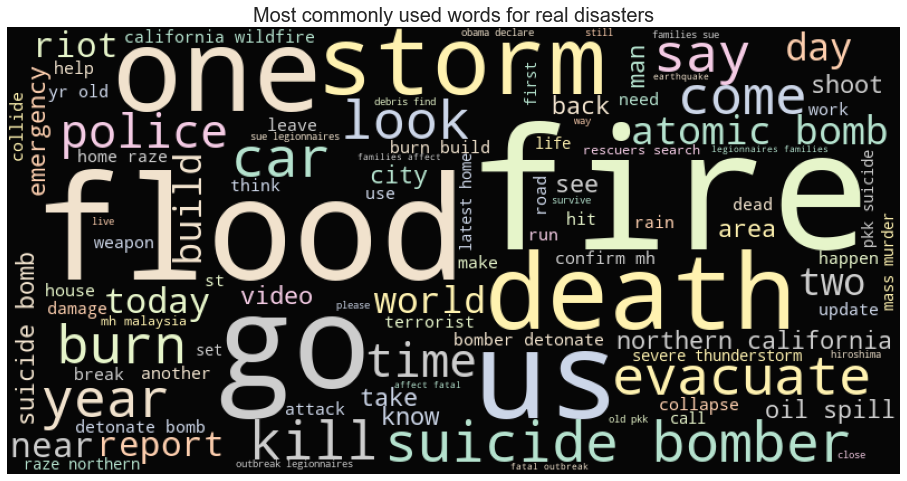

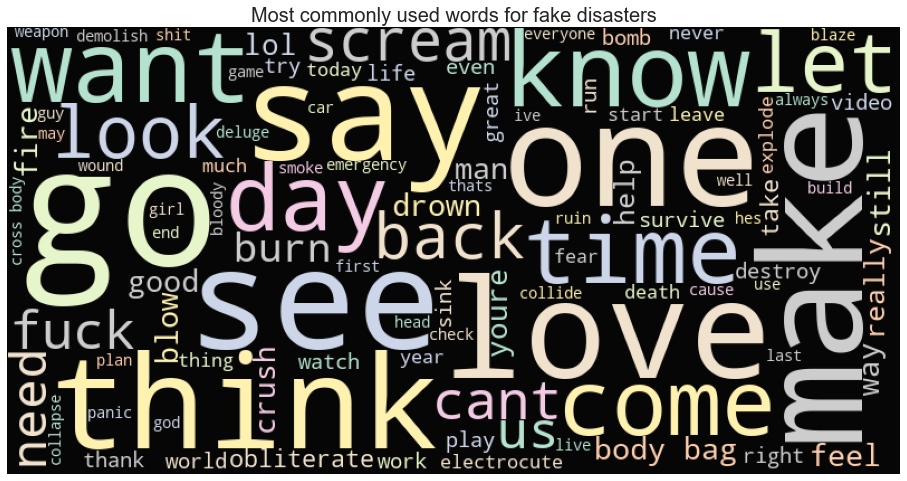

In [61]:
from wordcloud import WordCloud


def generate_wordcloud(words,sentiment):
    plt.figure(figsize=(16,13))
    wc = WordCloud(background_color="black", max_words=100, max_font_size=150, width=800, height=400)
    wc.generate(words)
    plt.title("Most commonly used words for {} disasters".format(sentiment), fontsize=20)
    plt.imshow(wc.recolor(colormap='Pastel2', random_state=17), alpha=0.98)
    plt.axis('off')
    

print("Creating word clouds...")
positive_words=" ".join(train[train.target==1]['clean'].values)
negative_words=" ".join(train[train.target==0]['clean'].values)

generate_wordcloud(positive_words,"real")
generate_wordcloud(negative_words,"fake")

# 3. Modelling

In [62]:
# helper function to show results and charts
def show_summary_report(actual, prediction, predict_proba):

    if isinstance(actual, pd.Series):
        actual = actual.values
    if actual.dtype.name == 'object':
        actual = actual.astype(int)
    if prediction.dtype.name == 'object':
        prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, predict_proba)

    print('Accuracy : %.4f [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, prediction)
    average_precision = average_precision_score(actual, prediction)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, predict_proba)
    roc_auc = auc(fpr, tpr)

    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, annot_kws={"size": 16}, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    label_font = {'size':'15'} 
    title_font = {'size':'21'}
    
    ax[0].set_title('Confusion Matrix', fontdict=title_font)
    ax[0].set_xlabel('True label', fontdict=label_font)
    ax[0].set_ylabel('Predicted label', fontdict=label_font)
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall', fontdict=label_font)
    ax[1].set_ylabel('Precision', fontdict=label_font)
    ax[1].set_title('2-class Precision-Recall curve', fontdict=title_font)

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate', fontdict=label_font)
    ax[2].set_ylabel('True Positive Rate', fontdict=label_font)
    ax[2].set_title('Receiver Operating Characteristic', fontdict=title_font)
    ax[2].legend(loc = 'lower right',  prop={'size': 15})

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

# 3.2 Set Feature Labels

In [63]:
# Features and Labels
X = train['clean']
y = train['target']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

print("Data distribution:\n- Train: {} \n- Test: {}".format(len(y_train),len(y_test)))

Data distribution:
- Train: 6090 
- Test: 1523


# 4. Feature Engineering

## 4.A Use CountVectorizer as Feature

In [64]:
# create a matrix of word counts from the text
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# do the actual counting
A = count_vect.fit_transform(X_train, y_train)

# Transform documents to document-term matrix.
X_train_count = count_vect.transform(X_train)
X_test_count = count_vect.transform(X_test)

## 4.B Use TF-IDF as Feature

- Word Level
- N-Gram Level

### 4.B.1 Word Level

In [65]:
# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

B1 = tfidf_vect.fit(X_train, y_train)
X_train_tfidf = tfidf_vect.transform(X_train)
X_test_tfidf  = tfidf_vect.transform(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)


### 4.B.2 N-Gram Level

In [66]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

B2 = tfidf_vect_ngram.fit(X_train, y_train)
X_train_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
X_test_tfidf_ngram  = tfidf_vect_ngram.transform(X_test)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=5000,
                min_df=1, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='\\w{1,}', tokenizer=None,
                use_idf=True, vocabulary=None)
Wall time: 385 ms


# 5. Text Classification

## 5.A Naive Bayes Classifier

### 5.A.1 Count Vectorizer

In [67]:
model_5_A = MultinomialNB()

# fit the training dataset on the classifier

A1 =  model_5_A.fit(X_train_count, y_train)

# predict the labels on validation dataset

predictions_A1 = model_5_A.predict(X_test_count)
predict_proba_A1 = model_5_A.predict_proba(X_test_count)[:,1]

### 5.A.2 Naive Bayes on Word Level TF IDF Vectors

In [68]:
A2 = model_5_A.fit(X_train_tfidf, y_train)

predictions_A2 = model_5_A.predict(X_test_tfidf)
predict_proba_A2 = model_5_A.predict_proba(X_test_tfidf)[:,1]

### 5.A.3 Naive Bayes on Ngram Level TF IDF Vectors

In [69]:
A3 = model_5_A.fit(X_train_tfidf_ngram, y_train)

predictions_A3 = model_5_A.predict(X_test_tfidf_ngram)
predict_proba_A3 = model_5_A.predict_proba(X_test_tfidf_ngram)[:,1]

## 5.B Linear Classifier

### 5.B.1 Linear Classifier on Count Vectors

In [70]:
model_5_B = LogisticRegression(solver = 'lbfgs', max_iter = 100)


# fit the training dataset on the classifier

B1 =  model_5_B.fit(X_train_count, y_train)

# predict the labels on validation dataset

predictions_B1 = model_5_B.predict(X_test_count)
predict_proba_B1 = model_5_B.predict_proba(X_test_count)[:,1]

### 5.B.2 Linear Classifier on Word Level TF IDF Vectors

In [71]:
B2 = model_5_B.fit(X_train_tfidf, y_train)

predictions_B2 = model_5_B.predict(X_test_tfidf)
predict_proba_B2 = model_5_B.predict_proba(X_test_tfidf)[:,1]

### 5.B.3 Linear Classifier on Ngram Level TF IDF Vectors

In [72]:
B3 = model_5_B.fit(X_train_tfidf_ngram, y_train)

predictions_B3 = model_5_B.predict(X_test_tfidf_ngram)
predict_proba_B3 = model_5_B.predict_proba(X_test_tfidf_ngram)[:,1]

## 5.C Support Vector Classifier

### 5.C.1 Support Vector Classifier on Count Vectors

In [73]:
# define model

model_5_C = SVC(kernel='linear', probability=True)

# fit the training dataset on the classifier

C1 =  model_5_C.fit(X_train_count, y_train)

# predict the labels on validation dataset

predictions_C1 = model_5_C.predict(X_test_count)
predict_proba_C1 = model_5_C.predict_proba(X_test_count)[:,1]

### 5.C.2 Support Vector Classifier on Word Level TF IDF Vectors

In [74]:
C2 = model_5_C.fit(X_train_tfidf, y_train)

predictions_C2 = model_5_C.predict(X_test_tfidf)
predict_proba_C2 = model_5_C.predict_proba(X_test_tfidf)[:,1]

### 5.C.3 Support Vector Classifier on Ngram Level TF IDF Vectors

In [75]:
C3 = model_5_C.fit(X_train_tfidf_ngram, y_train)

predictions_C3 = model_5_C.predict(X_test_tfidf_ngram)
predict_proba_C3 = model_5_C.predict_proba(X_test_tfidf_ngram)[:,1]

## 5.D Bagging Models

### 5.D.1 Bagging (Random Forest) on Count Vectors

In [76]:
%%time
# define model

model_5_D = RandomForestClassifier(n_estimators = 100)

# fit the training dataset on the classifier

D1 =  model_5_D.fit(X_train_count, y_train)

# predict the labels on validation dataset

predictions_D1 = model_5_D.predict(X_test_count)
predict_proba_D1 = model_5_D.predict_proba(X_test_count)[:,1]

Wall time: 6.52 s


### 5.D.2 Bagging (Random Forest) on Word Level TF IDF Vectors

In [77]:
%%time
D2 = model_5_D.fit(X_train_tfidf, y_train)

predictions_D2 = model_5_D.predict(X_test_tfidf)
predict_proba_D2 = model_5_D.predict_proba(X_test_tfidf)[:,1]

Wall time: 6.03 s


### 5.D.3 Bagging (Random Forest) on Ngram Level TF IDF Vectors

In [78]:
%%time
D3 = model_5_D.fit(X_train_tfidf_ngram, y_train)

predictions_D3 = model_5_D.predict(X_test_tfidf_ngram)
predict_proba_D3 = model_5_D.predict_proba(X_test_tfidf_ngram)[:,1]

Wall time: 5.58 s


## 5.E Boosting Models

### 5.E.1 Gradient Boosting on Count Vectors

In [79]:
%%time
# define model

model_5_E = GradientBoostingClassifier()

# fit the training dataset on the classifier

E1 =  model_5_E.fit(X_train_count, y_train)

# predict the labels on validation dataset

predictions_E1 = model_5_E.predict(X_test_count)
predict_proba_E1 = model_5_E.predict_proba(X_test_count)[:,1]

Wall time: 733 ms


### 5.E.2 Gradient Boosting on Word Level TF IDF Vectors

In [80]:
%%time

E2 = model_5_E.fit(X_train_tfidf, y_train)

predictions_E2 = model_5_E.predict(X_test_tfidf)
predict_proba_E2 = model_5_E.predict_proba(X_test_tfidf)[:,1]

Wall time: 1.32 s


### 5.E.3 Gradient Boosting on Ngram Level TF IDF Vectors

In [81]:
%%time
E3 = model_5_E.fit(X_train_tfidf_ngram, y_train)

predictions_E3 = model_5_E.predict(X_test_tfidf_ngram)
predict_proba_E3 = model_5_E.predict_proba(X_test_tfidf_ngram)[:,1]

Wall time: 610 ms


# 6. Show Summary Report

## 6.A Naive Bayes

Accuracy : 0.8102 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8067 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7339 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8628                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


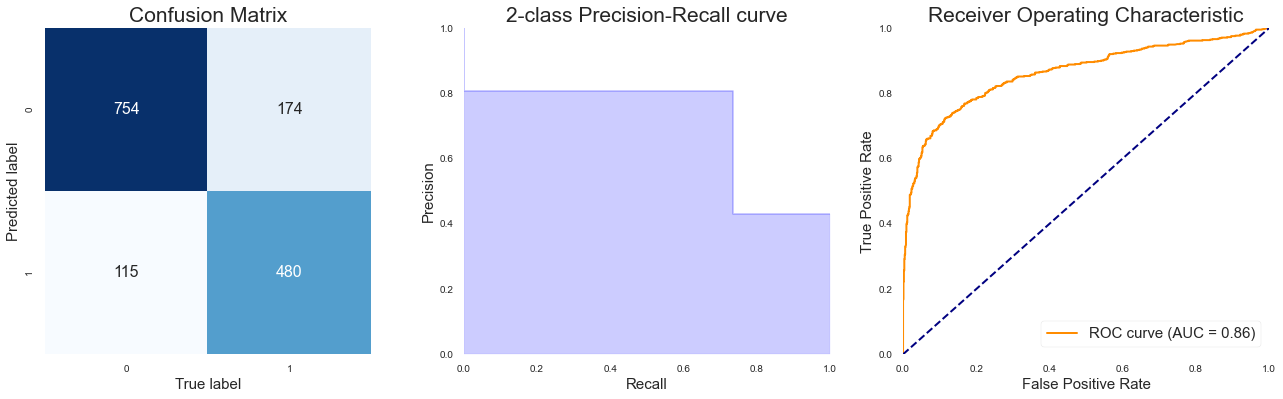

(0.8102429415627052,
 0.8067226890756303,
 0.7339449541284404,
 0.8627768217537117)

In [82]:
show_summary_report(y_test, predictions_A1, predict_proba_A1)

Accuracy : 0.8214 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8563 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7018 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8645                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


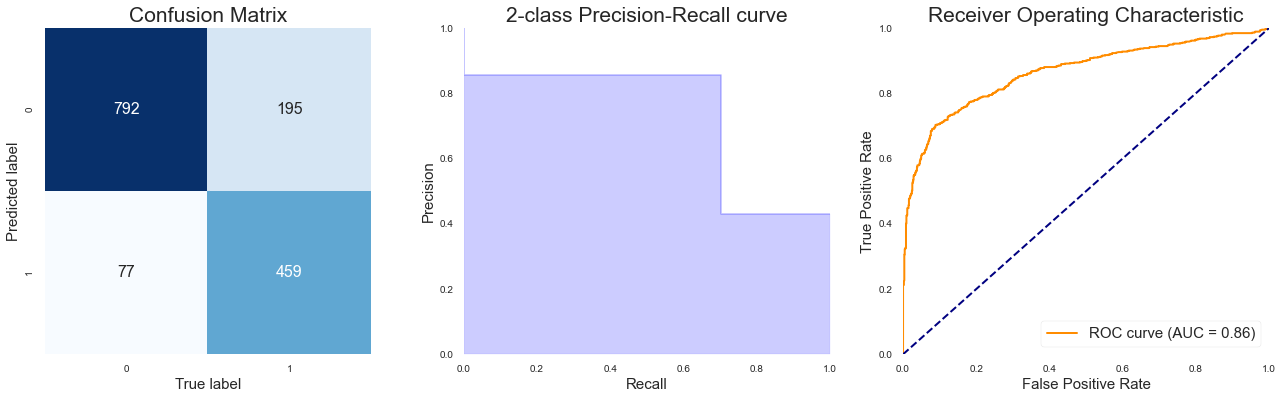

(0.8214051214707814,
 0.8563432835820896,
 0.7018348623853211,
 0.8645064628399897)

In [83]:
show_summary_report(y_test, predictions_A2, predict_proba_A2)

Accuracy : 0.7498 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8845 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4801 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7473                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


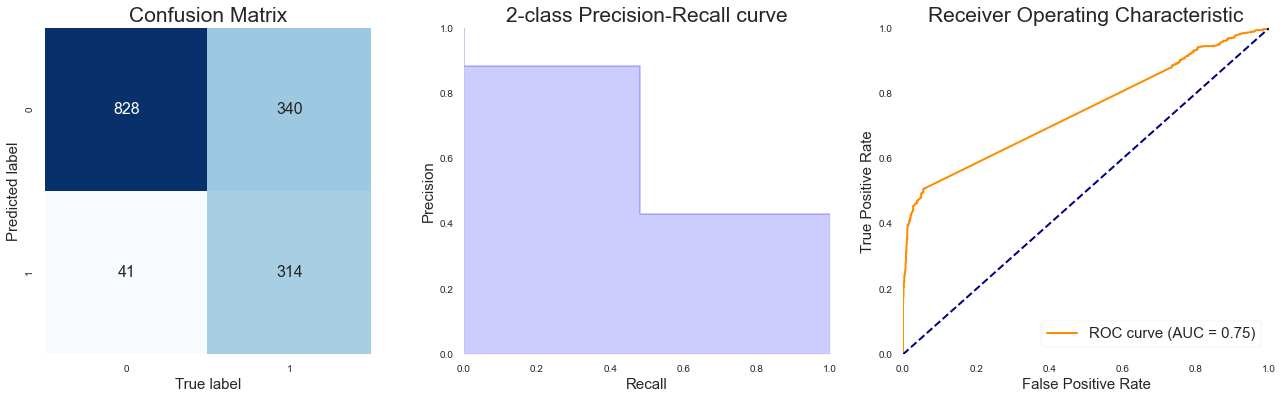

(0.7498358502954695,
 0.8845070422535212,
 0.4801223241590214,
 0.7473122820353106)

In [84]:
show_summary_report(y_test, predictions_A3, predict_proba_A3)

## 6.B Linear Classifier

Accuracy : 0.8070 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8051 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7263 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8570                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


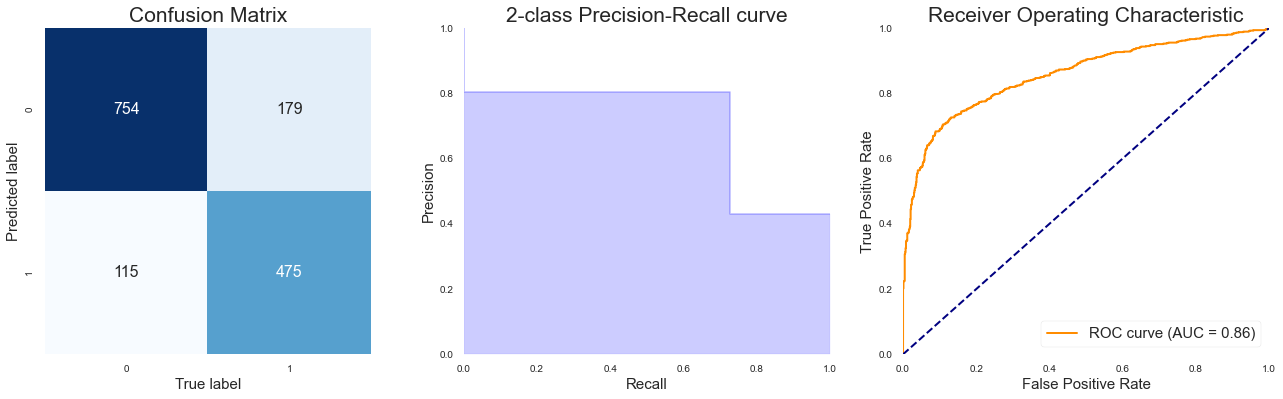

(0.8069599474720945, 0.8050847457627118, 0.7262996941896025, 0.856979092985364)

In [85]:
show_summary_report(y_test, predictions_B1, predict_proba_B1)

Accuracy : 0.8142 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8454 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6942 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8665                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


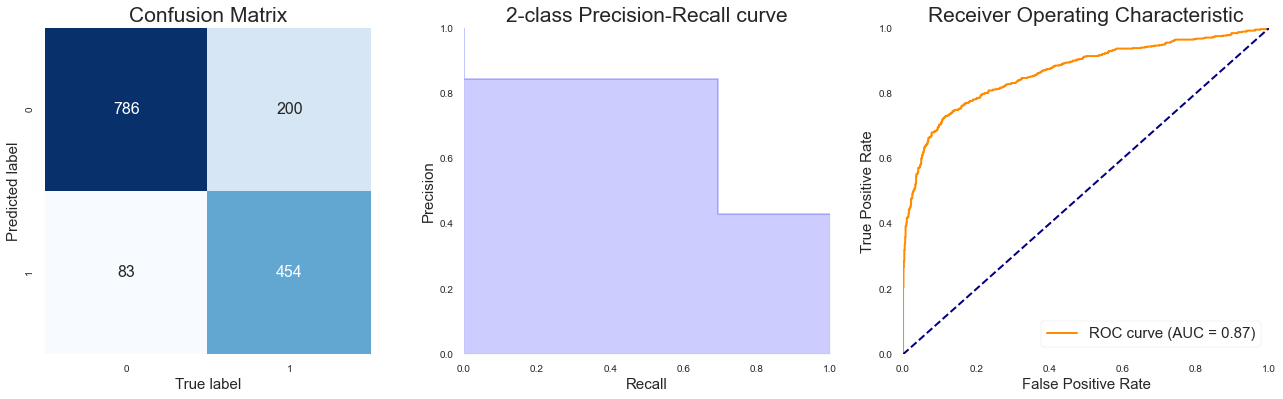

(0.814182534471438, 0.845437616387337, 0.6941896024464832, 0.8664683649877007)

In [86]:
show_summary_report(y_test, predictions_B2, predict_proba_B2)

Accuracy : 0.7525 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8924 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4817 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7485                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


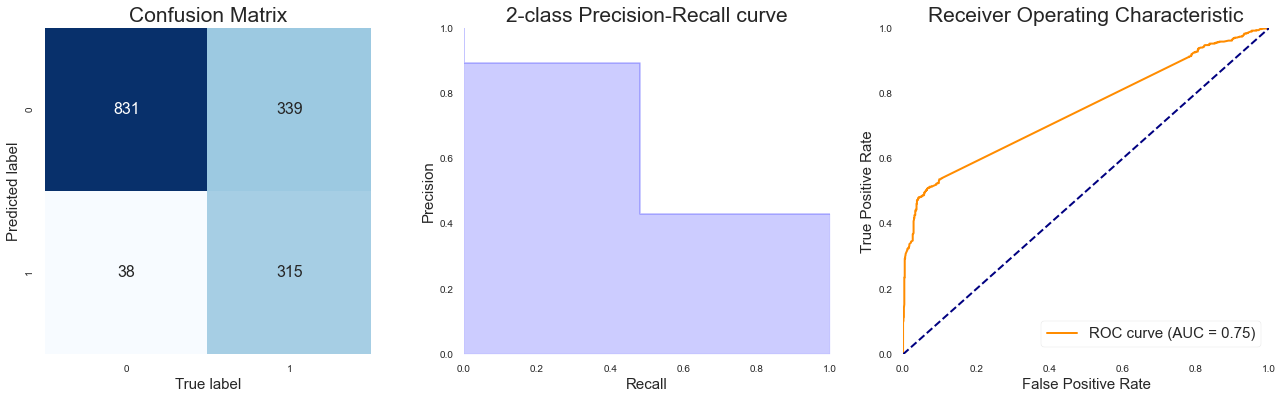

(0.7524622455679579, 0.8923512747875354, 0.481651376146789, 0.7484639097982495)

In [87]:
show_summary_report(y_test, predictions_B3, predict_proba_B3)

## 6.C SVC

Accuracy : 0.7676 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7381 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7110 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8321                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


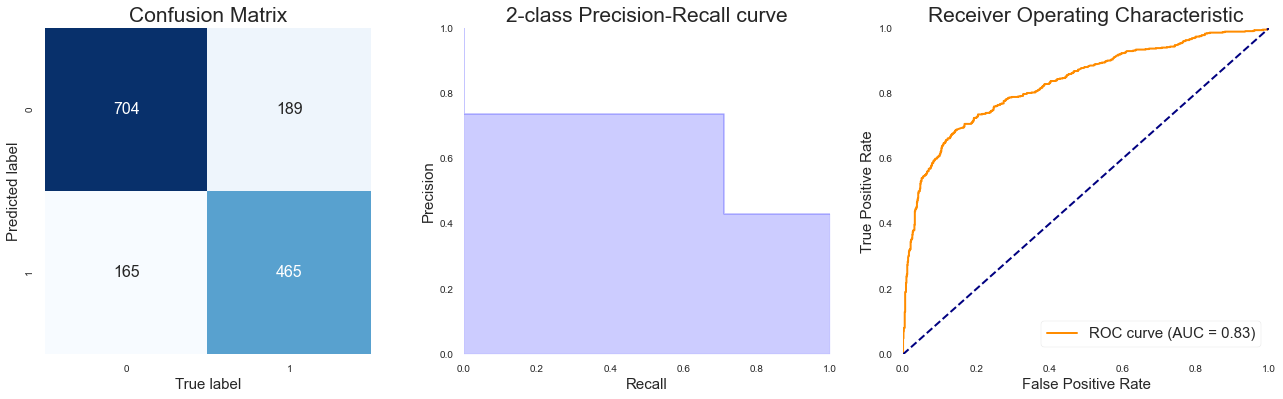

(0.767564018384767, 0.7380952380952381, 0.7110091743119266, 0.8320902087886178)

In [88]:
show_summary_report(y_test, predictions_C1, predict_proba_C1)

Accuracy : 0.8142 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8249 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7202 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8583                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


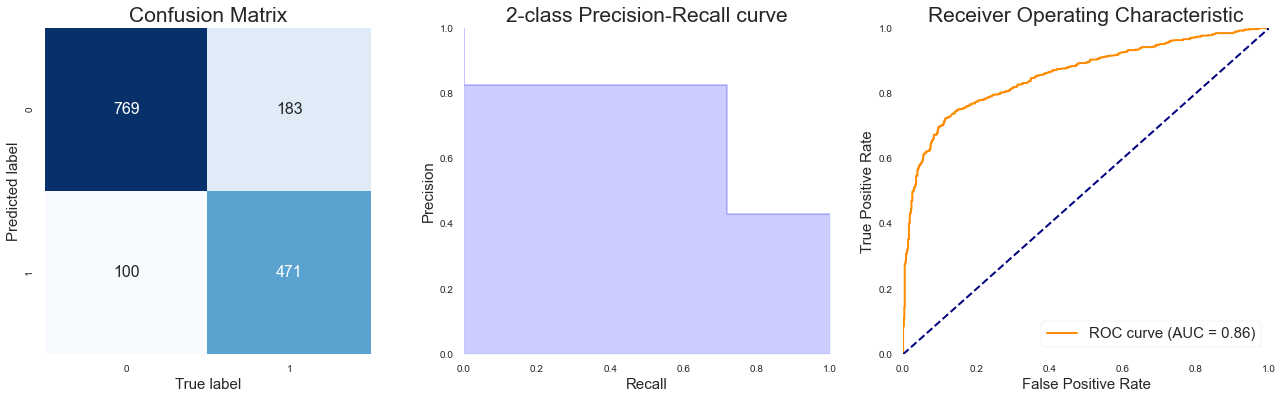

(0.814182534471438, 0.8248686514886164, 0.7201834862385321, 0.8582838019024293)

In [89]:
show_summary_report(y_test, predictions_C2, predict_proba_C2)

Accuracy : 0.7446 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8711 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4755 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7281                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


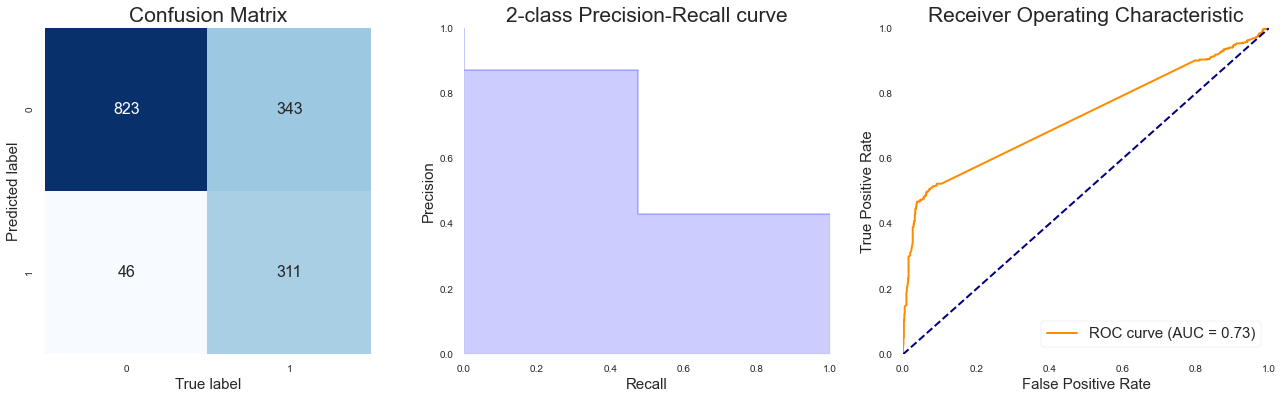

(0.7445830597504924,
 0.8711484593837535,
 0.47553516819571867,
 0.7280777229970122)

In [90]:
show_summary_report(y_test, predictions_C3, predict_proba_C3)

## 6.D Bagging Models

Accuracy : 0.7859 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7706 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7141 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8383                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


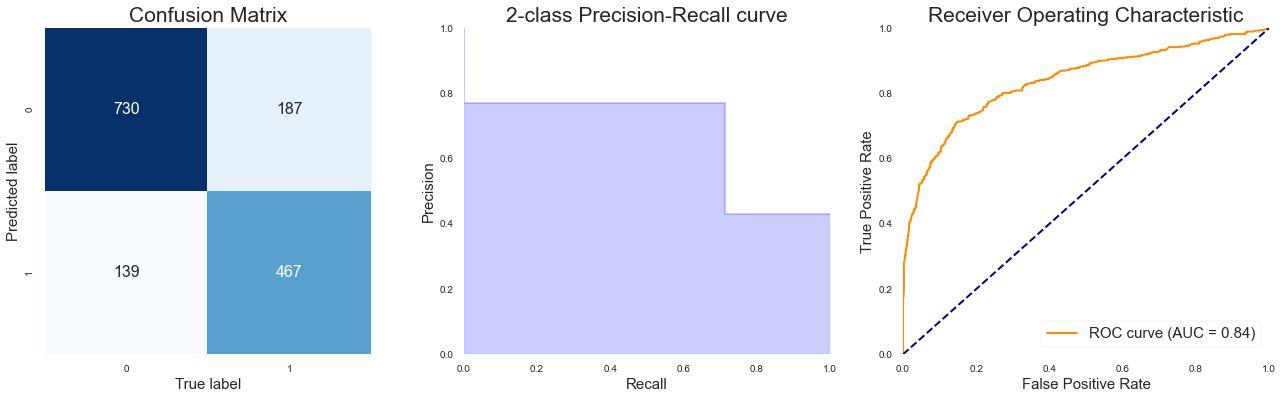

(0.7859487852921865,
 0.7706270627062707,
 0.7140672782874617,
 0.8383401428053617)

In [91]:
show_summary_report(y_test, predictions_D1, predict_proba_D1)

Accuracy : 0.7912 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7781 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7187 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8482                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


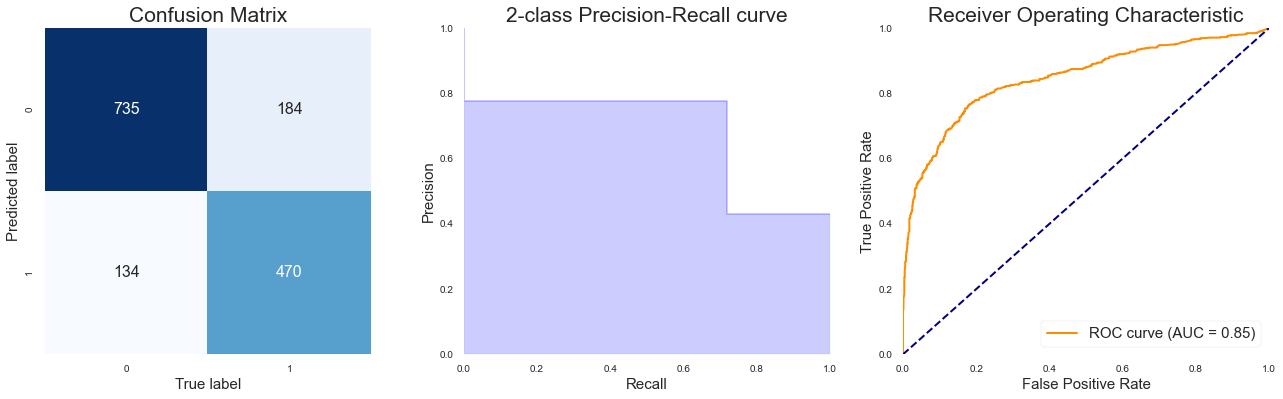

(0.7912015758371634,
 0.7781456953642384,
 0.7186544342507645,
 0.8482420301024411)

In [92]:
show_summary_report(y_test, predictions_D2, predict_proba_D2)

Accuracy : 0.7452 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8595 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.4862 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.7437                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


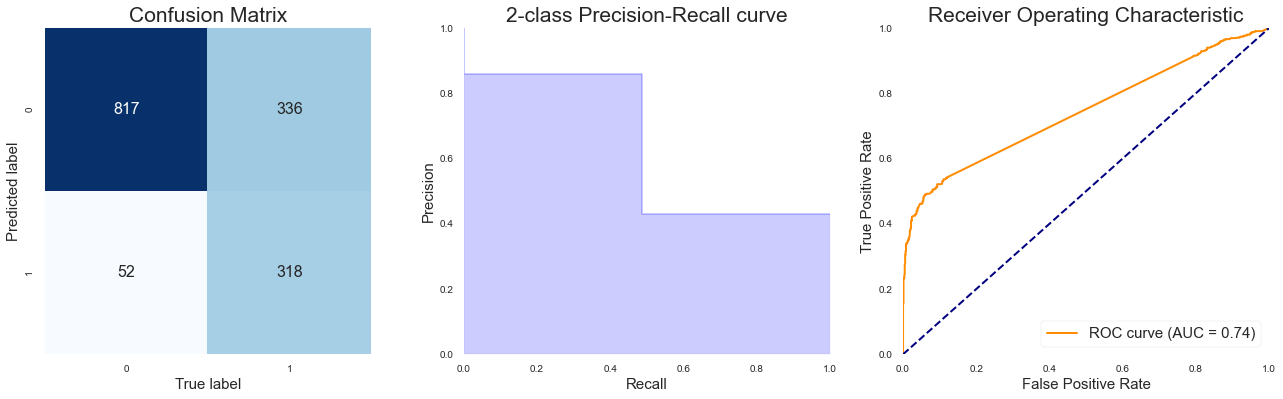

(0.7452396585686146,
 0.8594594594594595,
 0.48623853211009177,
 0.7437456670995168)

In [93]:
show_summary_report(y_test, predictions_D3, predict_proba_D3)

## 6.E Boosting Models

Accuracy : 0.7557 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8711 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.5061 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8182                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


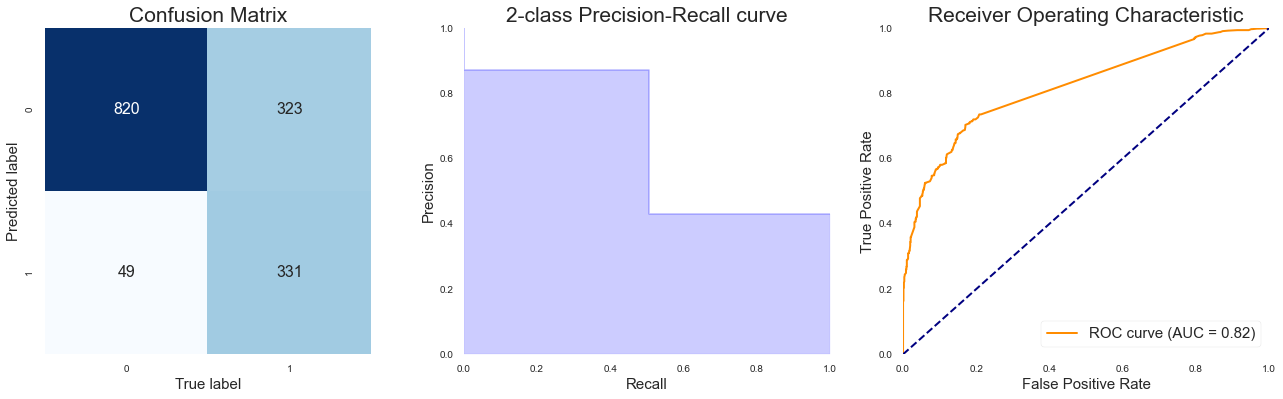

(0.7557452396585687,
 0.8710526315789474,
 0.5061162079510704,
 0.8181976541632795)

In [94]:
show_summary_report(y_test, predictions_E1, predict_proba_E1)

Accuracy : 0.7571 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8550 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.5229 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8070                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


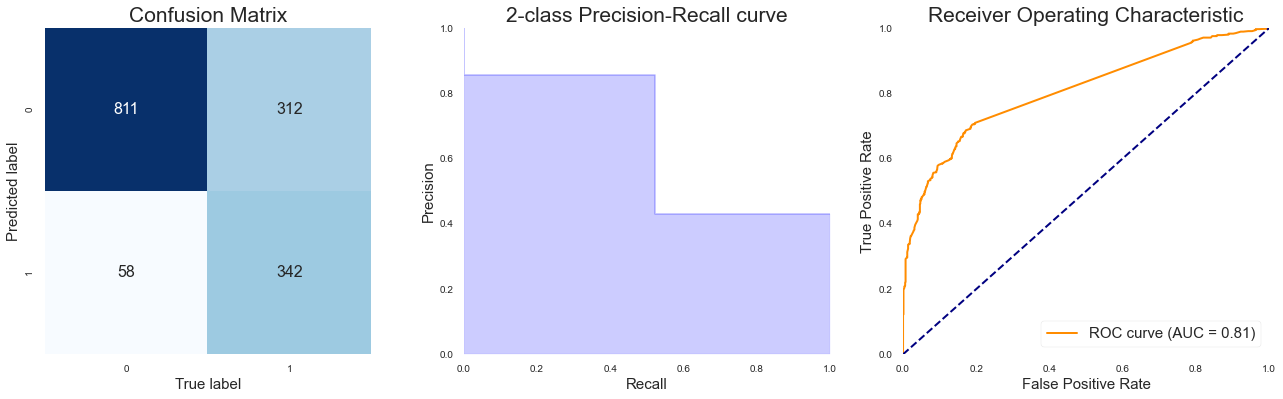

(0.7570584372948129, 0.855, 0.5229357798165137, 0.8069549871024727)

In [95]:
show_summary_report(y_test, predictions_E2, predict_proba_E2)

Accuracy : 0.6901 [(TP + TN) / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9292 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.3012 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.6711                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


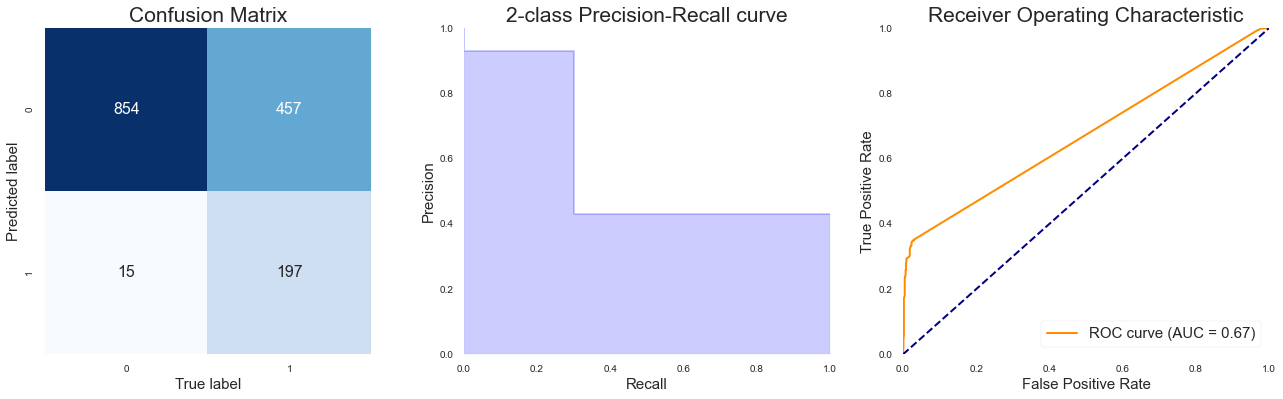

(0.6900853578463558,
 0.9292452830188679,
 0.3012232415902141,
 0.6711139381270611)

In [96]:
show_summary_report(y_test, predictions_E3, predict_proba_E3)

# 7. Summary Table

In [97]:
results = {
    'NB Count Vectorizer' : [accuracy_score(y_test, predictions_A1), precision_score(y_test, predictions_A1), recall_score(y_test, predictions_A1), roc_auc_score(y_test, predict_proba_A1)],
    'NB TF-IDF Vectorizer': [accuracy_score(y_test, predictions_A2), precision_score(y_test, predictions_A2), recall_score(y_test, predictions_A2), roc_auc_score(y_test, predict_proba_A2)],
    'NB TF-IDF N-Gram': [accuracy_score(y_test, predictions_A3), precision_score(y_test, predictions_A3), recall_score(y_test, predictions_A3), roc_auc_score(y_test, predict_proba_A3)],
    'LC Count Vectorizer': [accuracy_score(y_test, predictions_B1), precision_score(y_test, predictions_B1), recall_score(y_test, predictions_B1), roc_auc_score(y_test, predict_proba_B1)],
    'LC TF-IDF Vectorizer': [accuracy_score(y_test, predictions_B2), precision_score(y_test, predictions_B2), recall_score(y_test, predictions_B2), roc_auc_score(y_test, predict_proba_B2)],
    'LC TF-IDF N-Gram': [accuracy_score(y_test, predictions_B3), precision_score(y_test, predictions_B3), recall_score(y_test, predictions_B3), roc_auc_score(y_test, predict_proba_B3)],
    'SVC Count Vectorizer': [accuracy_score(y_test, predictions_C1), precision_score(y_test, predictions_C1), recall_score(y_test, predictions_C1), roc_auc_score(y_test, predict_proba_C1)],
    'SVC TF-IDF Vectorizer': [accuracy_score(y_test, predictions_C2), precision_score(y_test, predictions_C2), recall_score(y_test, predictions_C2), roc_auc_score(y_test, predict_proba_C2)],
    'SVC TF-IDF N-Gram': [accuracy_score(y_test, predictions_C3), precision_score(y_test, predictions_C3), recall_score(y_test, predictions_C3), roc_auc_score(y_test, predict_proba_C3)],
    'RF Count Vectorizer': [accuracy_score(y_test, predictions_D1), precision_score(y_test, predictions_D1), recall_score(y_test, predictions_D1), roc_auc_score(y_test, predict_proba_D1)],
    'RF TF-IDF Vectorizer': [accuracy_score(y_test, predictions_D2), precision_score(y_test, predictions_D2), recall_score(y_test, predictions_D2), roc_auc_score(y_test, predict_proba_D2)],
    'RF TF-IDF N-Gram': [accuracy_score(y_test, predictions_D3), precision_score(y_test, predictions_D3), recall_score(y_test, predictions_D3), roc_auc_score(y_test, predict_proba_D3)],
    'GB Count Vectorizer': [accuracy_score(y_test, predictions_E1), precision_score(y_test, predictions_E1), recall_score(y_test, predictions_E1), roc_auc_score(y_test, predict_proba_E1)],
    'GB TF-IDF Vectorizer': [accuracy_score(y_test, predictions_E2), precision_score(y_test, predictions_E2), recall_score(y_test, predictions_E2), roc_auc_score(y_test, predict_proba_E2)],
    'GB TF-IDF N-Gram': [accuracy_score(y_test, predictions_E3), precision_score(y_test, predictions_E3), recall_score(y_test, predictions_E3), roc_auc_score(y_test, predict_proba_E3)],
        
}    

scores = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'ROC_AUC'] , columns=['NB Count Vectorizer','NB TF-IDF Vectorizer', 'NB TF-IDF N-Gram', 'LC Count Vectorizer', 'LC TF-IDF Vectorizer', 'LC TF-IDF N-Gram', 'SVC Count Vectorizer', 'SVC TF-IDF Vectorizer', 'SVC TF-IDF N-Gram', 'RF Count Vectorizer', 'RF TF-IDF Vectorizer', 'RF TF-IDF N-Gram', 'GB Count Vectorizer', 'GB TF-IDF Vectorizer', 'GB TF-IDF N-Gram'])
scores

,NB Count Vectorizer,NB TF-IDF Vectorizer,NB TF-IDF N-Gram,LC Count Vectorizer,LC TF-IDF Vectorizer,LC TF-IDF N-Gram,SVC Count Vectorizer,SVC TF-IDF Vectorizer,SVC TF-IDF N-Gram,RF Count Vectorizer,RF TF-IDF Vectorizer,RF TF-IDF N-Gram,GB Count Vectorizer,GB TF-IDF Vectorizer,GB TF-IDF N-Gram
Accuracy,0.810243,0.821405,0.749836,0.806960,0.814183,0.752462,0.767564,0.814183,0.744583,0.785949,0.791202,0.745240,0.755745,0.757058,0.690085
Precision,0.806723,0.856343,0.884507,0.805085,0.845438,0.892351,0.738095,0.824869,0.871148,0.770627,0.778146,0.859459,0.871053,0.855000,0.929245
Recall,0.733945,0.701835,0.480122,0.726300,0.694190,0.481651,0.711009,0.720183,0.475535,0.714067,0.718654,0.486239,0.506116,0.522936,0.301223
ROC_AUC,0.862777,0.864506,0.747312,0.856979,0.866468,0.748464,0.832090,0.858284,0.728078,0.838340,0.848242,0.743746,0.818198,0.806955,0.671114
